# Deuteron electrodisintegration

_Last update:_ February 5, 2025

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy.linalg import det, norm, solve
from scipy.interpolate import InterpolatedUnivariateSpline, RectBivariateSpline
from scipy.special import lpmv, sph_harm
from sympy.physics.quantum.cg import CG

In [2]:
# Imports from scripts
from scripts.figures import set_rc_parameters, label_channel
from scripts.integration import (
    gaussian_quadrature_mesh, unattach_weights_from_vector
)
from scripts.momentum_distributions import PartialWaveChannel
from scripts.potentials import Potential
from scripts.tools import (
    build_coupled_channel_matrix, convert_l_to_string,
    decompose_coupled_channel_matrix
)
from scripts.wave_function import wave_function

### Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

## Classes

In [4]:
class ClebschGordan:
    """
    Class for computing Clebsch-Gordan coefficients using SymPy to precompute
    and storing values in a dictionary for look-up.
    """
    
    def __init__(self, j_max):
        
        # Precompute the table of Clebsch-Gordan coefficients
        self.cg_table = self.compute_clebsch_gordan_table(j_max)
    
    def compute_clebsch_gordan_table(self, j_max):
        """Calculate Clebsch-Gordan coefficients for combinations of j and m_j
        up to j_max.
    
        Parameters
        ----------
        j_max : int
            Maximum j value for j_1, j_2, and j_3. This also constrains m_j.
    
        Returns
        -------
        cg_table : dict
            Table of Clebsch-Gordan coefficients
                < j_1 m_j_1 j_2 m_j_2 | j_3 m_j_3 >
            for each combination of angular momenta.
        
        """
        
        cg_table = {}
        
        j_array = np.arange(0, j_max+1/2, 1/2)
    
        for j_1 in j_array:
            for j_2 in j_array:
                j_3_array = np.arange(abs(j_1-j_2), j_1+j_2+1)
                for j_3 in j_3_array:
                    for m_1 in np.arange(-j_1, j_1+1, 1):
                        for m_2 in np.arange(-j_2, j_2+1, 1):
                        
                            m_3 = m_1 + m_2
                        
                            if abs(m_3) <= j_3:
                                cg_table[(j_1, m_1, j_2, m_2, j_3, m_3)] = (
                                    float(
                                        CG(j_1, m_1, j_2, m_2, j_3, m_3).doit()
                                    )
                                )
                 
        return cg_table
    
    def get_coefficient(self, j_1, m_1, j_2, m_2, j_3, m_3):
        """Return the CG coefficient given input angular momentum."""
        
        return self.cg_table[(j_1, m_1, j_2, m_2, j_3, m_3)]
    
    def check_projection(self, j, m_j):
        """Check if angular momentum projection is physical."""
        
        return np.abs(m_j) <= j
    
    def is_physical(self, j_1, m_1, j_2, m_2, j_3, m_3):
        """Check if quantum numbers make sense."""
        
        m_1_bool = self.check_projection(j_1, m_1)
        m_2_bool = self.check_projection(j_2, m_2)
        j_3_bool = np.abs(j_1 - j_2) <= j_3 <= j_1 + j_2
        m_3_bool = m_3 == m_1 + m_2 and self.check_projection(j_3, m_3)
        
        return m_1_bool and m_2_bool and j_3_bool and m_3_bool

In [5]:
class FormFactors:
    """Form factors from Sushant's data files."""
    
    def __init__(self):
        """Interpolate data files."""
        
        gep_data = np.loadtxt("gep.dat")
        gen_data = np.loadtxt("gen.dat")
        
        Q2_gep_GeV = gep_data[:, 0]
        gep_array = gep_data[:, 1]
        Q2_gen_GeV = gen_data[:, 0]
        gen_array = gen_data[:, 1]
        
        self.gep_func = InterpolatedUnivariateSpline(Q2_gep_GeV, gep_array)
        self.gen_func = InterpolatedUnivariateSpline(Q2_gen_GeV, gen_array)
        
    def GEp(self, Q2):
        """Electric proton form factor w.r.t. Q^2 in GeV^2."""
        
        return self.gep_func(Q2) * self.GD(Q2)
    
    def GEn(self, Q2):
        """Electric neutron form factor w.r.t. Q^2 in GeV^2."""
        
        return self.gen_func(Q2)
    
    def GD(self, Q2):
        """Dipole form factor w.r.t. Q^2 in GeV^2."""
        
        mD2 = 0.71  # GeV^2
        
        return (1 + Q2 / mD2) ** -2

In [6]:
class TMatrix(Potential):
    """Class that computes the half off-shell T-matrix."""
    
    def __init__(self, kvnn, channel, kmax, kmid, ntot):
        
        # Set channel argument to be compatible with potential functions
        self.tmatrix_channel = channel
        potential_channel = coupled_channel_shorthand(channel)
        
        # POTENTIAL'S ATTRIBUTE CHANNEL (3S1 IS OVERWRITING T-MATRIX'S ATTRIBUTE CHANNEL 3S1-3D1)
        
        # Initialize Potential class
        super().__init__(kvnn, potential_channel, kmax, kmid, ntot)
        
        # Get potential in units fm
        V_matrix = self.load_potential()

        # Load momenta and weights in fm^-1
        self.k_array, self.k_weights = self.load_mesh()
        
        # Maximum momentum value in fm^-1
        self.k_max = round(max(self.k_array))
        
        # Number of points in momentum mesh
        self.ntot = ntot
        
        # Interpolate potential
        if self.coupled_channel_bool:
            
            # Get V sub-blocks
            V11, V12, V21, V22 = decompose_coupled_channel_matrix(V_matrix)
        
            # Interpolate each sub-block separately
            self.V11_func = RectBivariateSpline(self.k_array, self.k_array, V11)
            self.V12_func = RectBivariateSpline(self.k_array, self.k_array, V12)
            self.V21_func = RectBivariateSpline(self.k_array, self.k_array, V21)
            self.V22_func = RectBivariateSpline(self.k_array, self.k_array, V22)

#             ### TESTING
#             self.V11_func = RectBivariateSpline(self.k_array, self.k_array, V11, kx=1, ky=1)
#             self.V12_func = RectBivariateSpline(self.k_array, self.k_array, V12, kx=1, ky=1)
#             self.V21_func = RectBivariateSpline(self.k_array, self.k_array, V21, kx=1, ky=1)
#             self.V22_func = RectBivariateSpline(self.k_array, self.k_array, V22, kx=1, ky=1)
            
        else:
            
            self.V_func = RectBivariateSpline(self.k_array, self.k_array,
                                              V_matrix)

    def evaluate(self, pp):
        """Compute the T-matrix in units [fm] where we use the mesh k_i and
        p' with E' = p'^2 / M.
        """
        
        # First ntot elements of D_vector [fm^-1]
        D_vector = (2.0/np.pi * (self.k_weights * self.k_array ** 2)
                    / (self.k_array ** 2 - pp ** 2))
        # ntot+1 element of D_vector [fm^-1]
#         D_last = (
#             -2.0/np.pi * pp ** 2
#             * (np.sum(self.k_weights / (self.k_array ** 2 - pp ** 2))
#                + np.log((self.k_max + pp) / (self.k_max - pp)) / (2.0 * pp))
#         ) + 1j * pp
        
        ### TESTING
        D_last = (
            -2.0/np.pi * pp ** 2
            * (np.sum(self.k_weights / (self.k_array ** 2 - pp ** 2))
               + np.log((self.k_max + pp) / (self.k_max - pp)) / (2.0 * pp))
        ) - 1j * pp

        # Append ntot+1 element to D_vector
        D_vector = np.append(D_vector, D_last)  # Length is now ntot+1
        
        # p' can be appended to end of k_array regardless of its value
        k_full = np.append(self.k_array, pp)
        
        # Create meshes for interpolation
        k_grid, kp_grid = np.meshgrid(k_full, k_full, indexing='ij')
        
        if self.coupled_channel_bool:
            
            # Append p' points by using the interpolated potential
            V11_matrix = self.V11_func.ev(k_grid, kp_grid)
            V12_matrix = self.V12_func.ev(k_grid, kp_grid)
            V21_matrix = self.V21_func.ev(k_grid, kp_grid)
            V22_matrix = self.V22_func.ev(k_grid, kp_grid)
            
            # Build coupled-channel matrix
            V_matrix = build_coupled_channel_matrix(V11_matrix, V12_matrix,
                                                    V21_matrix, V22_matrix)

            # Build F matrix where F_ij = delta_ij + D_j V_ij
            F_matrix = (
                np.identity(2 * (self.ntot + 1))
                + np.tile(D_vector, (2 * (self.ntot + 1), 2)) * V_matrix
            )
            
        else:
            
            # Append p' points by using the interpolated potential
            V_matrix = self.V_func.ev(k_grid, kp_grid)
            
            # Build F matrix where F_ij = delta_ij + D_j V_ij
            F_matrix = (
                np.identity(self.ntot + 1)
                + np.tile(D_vector, (self.ntot + 1, 1)) * V_matrix
            )

        # Calculate T-matrix in fm
        T_matrix = solve(F_matrix, V_matrix)

        # Shape is (ntot+1, ntot+1) or (2*ntot+2, 2*ntot+2)
        return T_matrix
    
    def half_offshell(self, T_matrix):
        """Returns the half off-shell T-matrix T_{L, L'}(k_i, p') given a
        sub-block of the coupled-channel. Works for non-coupled-channels too.
        """
        
        if self.tmatrix_channel in ['3S1-3D1', '3P2-3F2', '3D3-3G3']:
            
            k_i_start, k_i_end = 0, self.ntot
            pp_index = 2 * self.ntot + 1
            
        elif self.tmatrix_channel in ['3D1-3S1', '3F2-3P2', '3G3-3D3']:
            
            k_i_start, k_i_end = self.ntot + 1, 2 * self.ntot + 1
            pp_index = self.ntot
            
        elif self.tmatrix_channel in ['3D1-3D1', '3F2-3F2', '3G3-3G3']:
            
            k_i_start, k_i_end = self.ntot + 1, 2 * self.ntot + 1
            pp_index = 2 * self.ntot + 1
        
        else:
            
            k_i_start, k_i_end = 0, self.ntot
            pp_index = self.ntot
            
        # Array with shape (ntot, 1)
        return T_matrix[k_i_start:k_i_end, pp_index]
    
    def onshell(self, T_matrix):
        """Returns the on-shell T-matrix T_{L, L'}(p', p') given a sub-block of
        the coupled-channel. Works for non-coupled-channels too.
        """
        
        if self.tmatrix_channel in ['3S1-3D1', '3P2-3F2', '3D3-3G3']:
            
            ipp_index = self.ntot
            jpp_index = 2 * self.ntot + 1
            
        elif self.tmatrix_channel in ['3D1-3S1', '3F2-3P2', '3G3-3D3']:
            
            ipp_index = 2 * self.ntot + 1
            jpp_index = self.ntot
            
        elif self.tmatrix_channel in ['3D1-3D1', '3F2-3F2', '3G3-3G3']:
            
            ipp_index = 2 * self.ntot + 1
            jpp_index = 2 * self.ntot + 1
        
        else:
            
            ipp_index = self.ntot
            jpp_index = self.ntot
            
        # Scalar
        return T_matrix[ipp_index, jpp_index]

In [7]:
class FinalState:
    """
    Final-state wave function without plane-wave term.
    """
    
    def __init__(self, kvnn, kmax, kmid, ntot):
        
        # Set table of Clebsch-Gordan coefficients with j_max = 2
        self.cg = ClebschGordan(2)
        
        self.kvnn, self.kmax, self.kmid, self.ntot = kvnn, kmax, kmid, ntot
        
    def __call__(self, pp):

        # Not sure about these!
        m_J_d = 0
        m_S_f = 0

        delta_psi = np.zeros(self.ntot, dtype=complex)
        for channel in ['3S1-3S1', '3S1-3D1']:
            
            tmatrix = TMatrix(self.kvnn, channel, self.kmax, self.kmid,
                              self.ntot)
            T_matrix = tmatrix.evaluate(pp)
            T_array = tmatrix.half_offshell(T_matrix)

            greens_func = 1 / (pp ** 2 - tmatrix.k_array ** 2)
            
            # Get quantum numbers
            pwc = PartialWaveChannel(channel)
            L1, L2, J1, S1, T1 = pwc.L, pwc.Lp, pwc.J, pwc.S, pwc.T
            
            cg = self.cg.get_coefficient(L2, m_J_d - m_S_f, S1, m_S_f, J1,
                                         m_J_d)
            
            tl_factor = 1 + (-1) ** T1 * (-1) ** L2
            
            delta_psi += (
                0.5 * np.sqrt(2/np.pi) * greens_func * T_array * cg * tl_factor
            )
            
        return tmatrix.k_array, delta_psi

In [8]:
class DeuteronElectrodisintegration:
    """
    Class that calculates the longitudinal structure function for deuteron
    electrodisintegration.
    """
    
    def __init__(
            self, L_max=2, kvnn=6, kmax=30.0, kmid=4.0, ntot=120,
            form_factor_test=False
    ):
        
        # Make sure all constants are in units fm^-1
        self.hbar_c = 197.32696  # \hbar c [MeV fm]
        M_n = 939.56563 / self.hbar_c  # Neutron mass [fm^-1]
        M_p = 938.27231 / self.hbar_c  # Proton mass [fm^-1]
        self.M = (M_p + M_n) / 2  # Nucleon mass [fm^-1]
        self.B_d = 2.224 / self.hbar_c  # Binding energy of deuteron [fm^-1]
        self.M_d = 2 * self.M - self.B_d  # Deuteron mass [fm^-1]
        self.alpha = 1 / 137.03599  # Fine structure constant
        
        # Set table of Clebsch-Gordan coefficients with j_max = L_max + 1
        self.cg = ClebschGordan(L_max + 1)
        
        # Interpolate deuteron wave function and set as instance attribute
        self.set_deuteron_wf(kvnn, kmax, kmid, ntot)
        
        # Set potential specifications as instance attributes
        self.kvnn, self.kmax, self.kmid, self.ntot = kvnn, kmax, kmid, ntot

        # Option to set form factors to 1 (GEp) and 0 (GEn)
        self.form_factor_test = form_factor_test

        # Load form factors from data files
        if not(form_factor_test):
            self.ff = FormFactors()
        
        # Set cos(\theta) integration mesh
        self.ntot_theta = 15
        self.theta_array, self.theta_weights = gaussian_quadrature_mesh(
            np.pi, self.ntot_theta)
        
        # Quantum numbers in nested sum for FSI term
        self.fsi_quantum_numbers = self.fsi_sum(L_max)
            
#             # Possible partial wave channels for T-matrix in FSI term
#             channels = self.get_channels(self.fsi_quantum_numbers)
            
#             # Pre-compute T-matrices for each channel
#             self.tmatrix_funcs = self.precompute_tmatrices(channels)

    def set_deuteron_wf(self, kvnn, kmax, kmid, ntot):
        """Set deuteron S- and D-wave functions as instance attributes."""

        # Set-up potential in 3S1-3D1 coupled channel
        potential = Potential(kvnn, '3S1', kmax, kmid, ntot)
        
        # Hamiltonian in MeV
        H_matrix = potential.load_hamiltonian()
        
        # Momentum mesh in fm^-1
        self.k_array, self.k_weights = potential.load_mesh()
        
        # Load deuteron wave function [unitless]
        psi_d_unitless = wave_function(H_matrix)
        # Convert to units fm^3/2
        psi_d_units = unattach_weights_from_vector(
            self.k_array, self.k_weights, psi_d_unitless, coupled_channel=True)
        # Split into S- and D-waves
        psi_0_array = psi_d_units[:ntot]  # S-wave [fm^3/2]
        psi_2_array = psi_d_units[ntot:]  # D-wave [fm^3/2]
        
        # Interpolate and set functions as instance attributes
        self.psi_0_func = InterpolatedUnivariateSpline(self.k_array,
                                                       psi_0_array)
        self.psi_2_func = InterpolatedUnivariateSpline(self.k_array,
                                                       psi_2_array)
        
    def fsi_sum(self, L_max):
        """Store all non-zero combinations of quantum numbers for nested sums
        in the FSI term.
        """
        
        # Store combinations of quantum numbers in dictionary with S_f, m_S_f,
        # and m_J_d serving as the key
        fsi_quantum_numbers = {}
        
        S_f_array = np.array([0, 1])
        m_J_d_array = np.array([-1, 0, 1])
        T_1_array = np.array([0, 1])
        L_array = np.arange(0, L_max + 1, 1)
        m_s_array = np.array([-1, 0, 1])
        L_d_array = np.array([0, 2])
        
        # Sum over quantum numbers
        for S_f in S_f_array:
            
            # Possible values of m_S_f
            m_S_f_array = np.arange(-S_f, S_f + 1, 1)
            for m_S_f in m_S_f_array:
                
                for m_J_d in m_J_d_array:
        
                    # The amplitude depends on these three quantum numbers
                    key = (S_f, m_S_f, m_J_d)
                    quantum_numbers = []
                
                    # Orbital angular momentum projection of L_1 is fixed
                    m_L_1 = m_J_d - m_S_f
        
                    for T_1 in T_1_array:
                        for L_1 in L_array:
                        
                            # T_1 and L_1 factor
                            factor_T1_L1 = 1 + (-1) ** T_1 * (-1) ** L_1
                            
                            # Possible values of J_1
                            J_1_array = np.arange(np.abs(L_1 - 1), L_1 + 2, 1)
                            
                            for J_1 in J_1_array:
                                
                                # Quantum number check
                                if self.cg.is_physical(
                                    L_1, m_L_1, 1, m_S_f, J_1, m_J_d
                                ):
                                    
                                    cg_J1_L1 = self.cg.get_coefficient(
                                        L_1, m_L_1, 1, m_S_f, J_1, m_J_d
                                    )
                                    
                                    for L_2 in L_array:
                                        
                                        # Get partial wave channel
                                        channel = convert_to_pwc(L_2, L_1, J_1,
                                                                 1, T_1)
                                        
                                        # Won't continue if channel = None
                                        if channel:

                                            for m_s in m_s_array:
                                                
                                                m_L_2d = m_J_d - m_s
                        
                                                for L_d in L_d_array:
                                
                                                    # Quantum number check
                                                    if self.cg.is_physical(
                                                        L_2, m_L_2d, 1, m_s,
                                                        J_1, m_J_d
                                                    ) and self.cg.is_physical(
                                                        L_d, m_L_2d, 1, m_s,
                                                        J_1, m_J_d
                                                    ):

                                                        cg_J1_L2 = (
                                                            self.cg.get_coefficient(
                                                                L_2, m_L_2d, 1, m_s,
                                                                J_1, m_J_d
                                                            )
                                                        )

                                                        cg_Jd_Ld = (
                                                            self.cg.get_coefficient(
                                                                L_d, m_L_2d, 1,
                                                                m_s, 1, m_J_d
                                                            )
                                                        )
                        
                                                        factor = (
                                                            factor_T1_L1
                                                            * cg_J1_L1
                                                            * cg_J1_L2
                                                            * cg_Jd_Ld
                                                        )
                        
                                                        # Append combination?
                                                        if factor != 0:
                            
                                                            quantum_numbers.append(
                                                                (
                                                                    channel,
                                                                    T_1, L_1,
                                                                    L_2, J_1,
                                                                    m_s, L_d
                                                                )
                                                            )
                    
                    # Add set of quantum numbers to dictionary
                    fsi_quantum_numbers[key] = quantum_numbers

        return fsi_quantum_numbers
    
    def get_channels(self, fsi_quantum_numbers):
        """Store all possible partial wave channels for T-matrix given L_max."""
        
        channels = []
        for key in fsi_quantum_numbers:
            quantum_numbers_list = fsi_quantum_numbers[key]
            for ele in quantum_numbers_list:
                channel = ele[0]
                if not(channel in channels):
                    channels.append(channel)
        
        return channels
    
    def precompute_tmatrices(self, channels):
        """Set-up all T-matrices for each partial wave channel."""
        
        # Store T(k_i, p'; E') as function of p' (E') in dictionary
        tmatrix_funcs = {}
        for channel in channels:
            tmatrix = TMatrix(self.kvnn, channel, self.kmax, self.kmid,
                              self.ntot)
            tmatrix_funcs[channel] = lambda pp: tmatrix.compute_half_offshell(
                pp
            )

        return tmatrix_funcs

    def omega(self, Ep_ifm, q):
        """Energy of virtual photon \omega in CoM frame [fm^-1]."""

        return Ep_ifm + 2 * self.M - np.sqrt(self.M_d ** 2 + q ** 2)

    def Q2(self, omega, q):
        """Four-momentum transfer squared Q^2 = -q^2 [GeV^2]."""
        
        # Q^2 in fm^-2
        Q2 = q ** 2 - omega ** 2
        
        # Convert Q^2 to GeV^2
        return Q2 * (self.hbar_c / 1000) ** 2  
    
    def p_prime(self, Ep_ifm):
        """Magnitude of proton momentum p' in CM frame [fm^-1]."""
        
        return np.sqrt(self.M * Ep_ifm + Ep_ifm ** 2 / 4)
    
    def E_prime(self, pp):
        """E' from p' [MeV]."""
        
        Ep_ifm = 2 * np.sqrt(self.M ** 2 + pp ** 2) - 2 * self.M
        
        # Return in units MeV
        return Ep_ifm * self.hbar_c
    
    def nucleon_energy(self, pp):
        """Energy of the proton (neutron) [fm^-1] using E'^2 = p'^2 + M^2."""

        return np.sqrt(self.M ** 2 + pp ** 2)
    
    def deuteron_energy(self, q):
        """Energy of the deuteron [fm^-1] using E_d^2 = q^2 + M_d^2."""

        return np.sqrt(self.M_d ** 2 + q ** 2)

    def longitudinal_sf(self, Ep, thetap, q, fsi=False):
        """Longitudinal structure function f_L [fm] where the arguments are E'
        [MeV], \theta' [deg], and q [fm^-1].
        """
        
        # Start at zero and sum S_f, m_S_f, and m_J_d
        f_L = 0.0
        
        # Convert E' to fm^-1
        Ep_ifm = Ep / self.hbar_c
        
        # Convert \theta' to radians
        thetap_radians = np.radians(thetap)

        # Kinematic variables p' [fm^-1], E_N [fm^-1], and E_d [fm^-1]
        pp = self.p_prime(Ep_ifm)
        self.E_N = self.nucleon_energy(pp)
        self.E_d = self.deuteron_energy(q)

        # Kinematic factor has units fm^-1
        kinematic_factor = -np.pi * np.sqrt(2 * self.alpha * pp * self.E_N
                                            * self.E_d / self.M_d)

        # Sum over S_f, m_S_f, and m_J_d
        S_f_array = np.array([0, 1])
        m_J_d_array = np.array([-1, 0, 1])
        for S_f in S_f_array:
            m_S_f_array = np.arange(-S_f, S_f + 1, 1)
            for m_S_f in m_S_f_array:
                for m_J_d in m_J_d_array:
                    
                    # Equation 2
                    # Overlap has units fm^3/2
                    overlap = self.overlap_ia(Ep_ifm, pp, thetap_radians, q,
                                              S_f, m_S_f, m_J_d)
                    
                    # Add FSI?
                    if fsi:
                        overlap += self.overlap_fsi(
                            Ep_ifm, pp, thetap_radians, q, S_f, m_S_f, m_J_d
                        )

                    # Amplitude of the longitudinal structure function
                    T = kinematic_factor * overlap  # fm^1/2
                    
                    # Add magnitude of amplitude squared to structure function
                    f_L += np.abs(T) ** 2
                    
        return f_L

    def overlap_ia(
            self, Ep_ifm, pp, thetap_radians, q, S_f, m_S_f, m_J_d, test=False
    ):
        """Overlap matrix element [fm^3/2] in the impulse approximation."""
        
        # Start at zero and sum over L_d
        overlap = 0 + 0j
        
        # Deuteron orbital angular momentum projection m_L_d = m_J_d - m_S_f
        m_L_d = m_J_d - m_S_f
        
        # Call electric form factors
        if self.form_factor_test:
            gep = 1.0
            gen = 0.0
        else:
            omega = self.omega(Ep_ifm, q)  # fm^-1
            Q2 = self.Q2(omega, q)  # GeV^2
            gep = self.ff.GEp(Q2)  # Unitless
            gen = self.ff.GEn(Q2)  # Unitless
        
        # Dot product p'_vector \dot q_vector
        pqx = pp * q * np.cos(thetap_radians)
        
        # Magnitude of momenta |p'_vector +/- q_vector / 2|
        pq_minus = np.sqrt(pp ** 2 + q ** 2 / 4 - pqx)
        pq_plus = np.sqrt(pp ** 2 + q ** 2 / 4 + pqx)
        
        # Angles between the unit vector z^\hat and p'_vector -/+ q_vector / 2
        theta_minus = np.arccos((pp * np.cos(thetap_radians) - q / 2)
                                / pq_minus)
        theta_plus = np.arccos((pp * np.cos(thetap_radians) + q / 2)
                               / pq_plus)
        
        # No dependence on \phi' -> Set to zero!
        phip = np.zeros_like(theta_minus)
        
        # Sum over deuteron orbital angular momentum L_d
        L_d_array = np.array([0, 2])
        for L_d in L_d_array:
            
            # Make sure |m_L_d| <= L_d
            if np.abs(m_L_d) <= L_d:
            
                # Clebsch-Gordan coefficient
                cg = self.cg.get_coefficient(L_d, m_L_d, 1, m_S_f, 1, m_J_d)
                
                # Spherical harmonics
                Ylm_minus = sph_harm(m_L_d, L_d, phip, theta_minus)
                Ylm_plus = sph_harm(m_L_d, L_d, phip, theta_plus)
                
                # Deuteron wave function in fm^3/2
                if L_d == 0:
                    psi_minus = self.psi_0_func(pq_minus)
                    psi_plus = self.psi_0_func(pq_plus)
                elif L_d == 2:
                    psi_minus = self.psi_2_func(pq_minus)
                    psi_plus = self.psi_2_func(pq_plus)

                overlap += np.sqrt(2 / np.pi) * cg * (
                    gep * psi_minus * Ylm_minus + gen * psi_plus * Ylm_plus
                )
                
        return overlap
    
    def overlap_fsi(
            self, Ep_ifm, pp, thetap_radians, q, S_f, m_S_f, m_J_d
    ):
        """Final state interaction overlap matrix element [fm^3/2]."""
        
        # Start at zero and sum over quantum numbers
        overlap = 0 + 0j
        
        # Call electric form factors
        if self.form_factor_test:
            gep = 1.0
            gen = 0.0
        else:
            omega = self.omega(Ep_ifm, q)  # fm^-1
            Q2 = self.Q2(omega, q)  # GeV^2
            gep = self.ff.GEp(Q2)  # Unitless
            gen = self.ff.GEn(Q2)  # Unitless
        
        # Meshgrids over k_2 and \theta
        theta_grid, k2_grid = np.meshgrid(self.theta_array, self.k_array,
                                          indexing='ij')
        _, dk2_grid = np.meshgrid(self.theta_weights, self.k_weights,
                                  indexing='ij')
        
        # Jacobian for \theta
        theta_jacobian = self.theta_weights * np.sin(self.theta_array)
        
        # Dot product k2_vector \dot q_vector
        k2qx_grid = k2_grid * q * np.cos(theta_grid)
        # Magnitude of momenta |k2_vector - q_vector / 2|
        k2q_minus_grid = np.sqrt(k2_grid ** 2 + q ** 2 / 4 - k2qx_grid)
        # Angle between the unit vector z^\hat and k2_vector - q_vector / 2
        alphap_theta_k2 = np.arccos((k2_grid * np.cos(theta_grid) - q / 2)
                                     / k2q_minus_grid)
        
        # Same stuff as above but for k_2 = p'
        ppqx_array = pp * q * np.cos(self.theta_array)
        ppq_minus_array = np.sqrt(pp ** 2 + q ** 2 / 4 - ppqx_array)
        alphap_theta_pp = np.arccos((pp * np.cos(self.theta_array) - q / 2)
                                    / ppq_minus_array)
        
        # No dependence on \phi' -> Set to zero!
        phip = 0.0

        # Denominator of Green's function
        greens_func_grid = 1 / (pp ** 2 - k2_grid ** 2)
        
#         ### TESTING
#         greens_plus = 1 / (pp + k2_grid)
#         greens_minus = 1 / (pp - k2_grid)
        
        # Loop over quantum numbers
        m_L_1 = m_J_d - m_S_f
        for quantum_numbers in self.fsi_quantum_numbers[(S_f, m_S_f, m_J_d)]:
            
            # Unpack quantum numbers
            channel, T_1, L_1, L_2, J_1, m_s, L_d = quantum_numbers
            
            # 1 + (-1)^T_1 (-1)^L_1 factor
            factor_T1_L1 = 1 + (-1) ** T_1 * (-1) ** L_1
            
            # Clebsch-Gordan coefficients
            m_L_2d = m_J_d - m_s
            # < L_1 m_L_1 S=1 m_S_f | J_1 m_J_d >
            cg_J1_L1 = self.cg.get_coefficient(L_1, m_L_1, 1, m_S_f, J_1, m_J_d)
            # < J_1 m_J_d | L_2 m_J_d - m_s S=1 m_s >
            cg_J1_L2 = self.cg.get_coefficient(L_2, m_L_2d, 1, m_s, J_1, m_J_d)
            # < L_d m_J_d - m_s S=1 m_s | J=1 m_J_d >
            cg_Jd_Ld = self.cg.get_coefficient(L_d, m_L_2d, 1, m_s, 1, m_J_d)
            
            # Spherical harmonic
            Y_L_1 = sph_harm(m_L_1, L_1, phip, thetap_radians)
            
            # Legendre polynomials
            P_L_2_array = lpmv(m_J_d - m_s, L_2, np.cos(self.theta_array))
            P_L_d_k2_grid = lpmv(m_J_d - m_s, L_d, np.cos(alphap_theta_k2))
            P_L_d_pp_array = lpmv(m_J_d - m_s, L_d, np.cos(alphap_theta_pp))

            # Call T-matrix for given partial wave channel
            tmatrix = TMatrix(self.kvnn, channel, self.kmax, self.kmid,
                              self.ntot)
            # Evaluate T-matrix for E' = p'^2 / M
            T_matrix = tmatrix.evaluate(pp)
            # Half off-shell T-matrix (shape is (ntot_k, 1))
            T_half_offshell_array = np.conj(tmatrix.half_offshell(T_matrix))
            # Convert to grid (shape is (ntot_theta, ntot_k))
            T_half_offshell_grid = np.tile(T_half_offshell_array,
                                           (self.ntot_theta, 1))
            # On-shell T-matrix (scalar)
            T_onshell = np.conj(tmatrix.onshell(T_matrix))
            
            # Deuteron wave function in fm^3/2
            if L_d == 0:
                psi_k2_grid = self.psi_0_func(k2q_minus_grid)
                psi_pp_array = self.psi_0_func(ppq_minus_array)
            elif L_d == 2:
                psi_k2_grid = self.psi_2_func(k2q_minus_grid)
                psi_pp_array = self.psi_2_func(ppq_minus_array)
            
            # Define functions f(k_2,\theta) where k_2 != p' and k_2 = p'
            f_k2_grid = (
                k2_grid ** 2 * T_half_offshell_grid * P_L_d_k2_grid
                * psi_k2_grid
            )
            f_pp_array = pp ** 2 * T_onshell * P_L_d_pp_array * psi_pp_array
            
            # Integral over k_2 with p' != k_2 [fm^3/2]
            integral_1 = np.sum(
                dk2_grid * f_k2_grid * greens_func_grid, axis=-1
            )
            
            # Integrate over k_2 with p' = k_2 [fm^-1]
            integral_2 = np.sum(dk2_grid * greens_func_grid, axis=-1)
            
            # Integrate over \theta
            lamb = tmatrix.k_max
            integrand_theta = P_L_2_array * (
                integral_1 - f_pp_array * (
                    integral_2 - 1/(2 * pp) * (
                        np.log((lamb + pp) / (lamb - pp)) + 1j * np.pi
                    )
                )
            )
            integral_theta = np.sum(theta_jacobian * integrand_theta)
            
#             ### TESTING SM VERSION
#             f_k2_grid = (
#                 k2_grid ** 2 * T_half_offshell_grid * greens_plus
#                 * P_L_d_k2_grid * psi_k2_grid
#             )
#             f_pp_array = (
#                 pp ** 2 * T_onshell / (2 * pp) * P_L_d_pp_array * psi_pp_array
#             )
            
#             # Integral over k_2 with p' != k_2 [fm^3/2]
#             integral_1 = np.sum(
#                 dk2_grid * f_k2_grid * greens_minus, axis=-1
#             )
            
#             # Integrate over k_2 with p' = k_2 [fm^-1]
#             integral_2 = np.sum(dk2_grid * greens_minus, axis=-1)
            
#             # Integrate over \theta
#             lamb = tmatrix.k_max
#             integrand_theta = P_L_2_array * (
#                 integral_1 - f_pp_array * (
#                     np.log((lamb - pp) / pp) + integral_2 - 1j * np.pi
#                 )
#             )
#             integral_theta = np.sum(theta_jacobian * integrand_theta)
            
            # Add partial wave contribution to overlap
            overlap += np.sqrt(2 / np.pi) * (
                (gep + (-1) ** T_1 * gen) * factor_T1_L1 * cg_J1_L1 * cg_J1_L2
                * cg_Jd_Ld * Y_L_1 * integral_theta
            )
        
        # Factor of 2 for < J_0 > = 2 < J_0^- > (Eq. 20 in More 2015)
        return 2 * overlap

## Functions

In [9]:
def is_odd(x):
    """Check if the integer x is odd."""
    
    # Even
    if x % 2 == 0:
        return False
    # Odd
    else:
        return True

In [10]:
def coupled_channel_shorthand(channel_full):
    """Convert partial wave channel string (e.g., 3D1-3S1) to shorthand
    notation (e.g., 3S1).
    """
    
    if channel_full[:3] == '3D1':
        channel_short = '3S1'
    elif channel_full[:3] == '3F2':
        channel_short = '3P2'
    elif channel_full[:3] == '3G3':
        channel_short == '3D3'
    else:
        channel_short = channel_full[:3]
        
    return channel_short

In [11]:
def convert_to_pwc(L, Lp, J, S, T):
    """Converts the quantum numbers to a string representing the partial wave
    channel. E.g., '3S1-3D1'. Returns None if unphysical.
    """
    
    # Check that channel is physical
    J_bool = (np.abs(L - S) <= J <= L + S) and (np.abs(Lp - S) <= J <= Lp + S)
    T_bool = is_odd(L + S + T) and is_odd(Lp + S + T)
    
    if J_bool and T_bool:
    
        # Total spin
        spin = f"{2*S+1:d}"
    
        # Total angular momentum
        ang_mom = f"{J:d}"
    
        # Total orbital angular momentum in spectroscopic notation
        orb_ang_mom_1 = convert_l_to_string(L).capitalize()
        orb_ang_mom_2 = convert_l_to_string(Lp).capitalize()
    
        # Partial wave channel as a string
        channel = (spin + orb_ang_mom_1 + ang_mom + '-' + spin + orb_ang_mom_2
                   + ang_mom)
        
    # Channel is unphysical
    else:
        
        channel = None

    return channel

In [12]:
def plot_delta_psi(pp, x_limits=(0,7), y_limits=(1e-4,1e1)):
    """Plot the magnitude of the FSI term in the final state wave function."""
    
    kvnn, kmax, kmid, ntot = 6, 30.0, 4.0, 120
    fsi = FinalState(kvnn, kmax, kmid, ntot)
    k_array, delta_psi_array = fsi(pp)
    
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 3))
    ax.semilogy(k_array, np.abs(delta_psi_array))
    # ax.semilogy(k_array, np.abs(delta_psi_array) / np.sqrt(4*np.pi))
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.set_title(label_channel('3S1', False) + '\t\t'
                 + rf"$p'={pp:.2f}\,$fm$^{{-1}}$")
    ax.set_xlabel(r"$k$ [fm$^{-1}$]", fontsize=16)
    ax.set_ylabel(r"$|\Delta \psi(k)|$ [fm$^3$]", fontsize=16);

In [13]:
def plot_fL_wrt_Ep(Ep_array, thetap, x_limits=None, y_limits=None):
    """Plot the longitudinal structure function with respect to E' where
    \omega = 0.
    """
    
    # AV18
    de = DeuteronElectrodisintegration()
    
    # Quasifree ridge where \omega = 0 (q in units fm^-1)
    q_array = np.sqrt((Ep_array / de.hbar_c + 2 * de.M) ** 2 - de.M_d ** 2)
    
    # Longitudinal structure function
    f_L_array = de.longitudinal_sf(Ep_array, thetap, q_array)
    
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 3))
    ax.plot(Ep_array, f_L_array, label='Impulse approximation')
    
    ### TESTING FSI
    f_L_fsi_array = np.zeros_like(f_L_array)
    for i, q in enumerate(q_array):
        Ep = Ep_array[i]
        f_L_fsi_array[i] = de.longitudinal_sf(Ep, thetap, q, fsi=True)
#         percent = (i+1) / len(q_array) * 100
#         print(f"{percent:.1f}% done.")
    ax.plot(Ep_array, f_L_fsi_array, label='FSI included')
    
    ### TESTING DIFFERENT MESH
    de_2 = DeuteronElectrodisintegration(kmax=25.0, kmid=4.0, ntot=120)
    f_L_array_2 = de_2.longitudinal_sf(Ep_array, thetap, q_array)
    f_L_fsi_array_2 = np.zeros_like(f_L_array_2)
    for i, q in enumerate(q_array):
        Ep = Ep_array[i]
        f_L_fsi_array_2[i] = de_2.longitudinal_sf(Ep, thetap, q, fsi=True)
    ax.plot(Ep_array, f_L_array_2, label='IA different mesh', ls='dashdot')
    ax.plot(Ep_array, f_L_fsi_array_2, label='FSI different mesh', ls='dashdot')
    
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.legend(fontsize=9, loc='upper right')
    
#     ### TESTING
#     ax.set_xticks(np.arange(10, 120, 10))
#     ax.set_yticks(np.arange(1,7,1))
#     print(f_L_array[0])
    
    ax.set_title(rf"$\theta' = {thetap:.1f}$ [deg]")
    ax.set_xlabel(r"$E'$ [MeV]", fontsize=16)
    ax.set_ylabel(r"$f_L$ [fm]", fontsize=16);

In [14]:
def plot_fL_wrt_thetap(Ep, thetap_array, q, x_limits=None, y_limits=None):
    """Plot the longitudinal structure function with respect to E'."""
    
    # AV18
    de = DeuteronElectrodisintegration()

    # Longitudinal structure function
    f_L_array = de.longitudinal_sf(Ep, thetap_array, q)

    ### TESTING
#     print(f_L_array[0], f_L_array[-1])

    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 3))
    ax.plot(thetap_array, f_L_array, label='Impulse approximation')
    
    ### TESTING FSI
    f_L_fsi_array = de.longitudinal_sf(Ep, thetap_array, q, fsi=True)
    ax.plot(thetap_array, f_L_fsi_array, label='FSI included')

    ### TESTING DIFFERENT MESH
    de_2 = DeuteronElectrodisintegration(kmax=25.0, kmid=4.0, ntot=120)
    f_L_array_2 = de_2.longitudinal_sf(Ep, thetap_array, q)
    f_L_fsi_array_2 = de_2.longitudinal_sf(Ep, thetap_array, q, fsi=True)
    ax.plot(thetap_array, f_L_array_2, label='IA different mesh', ls='dashdot')
    ax.plot(thetap_array, f_L_fsi_array_2, label='FSI different mesh',
            ls='dashdot')
    
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.legend(fontsize=9, loc='upper right')
    ax.set_title(rf"$E'={Ep:d}$ [MeV], $\mathbf{{q}}^2={q**2:.1f}$ [fm$^{{-2}}$]")
    ax.set_xlabel(r"$\theta'$ [deg]", fontsize=16)
    ax.set_ylabel(r"$f_L$ [fm]", fontsize=16);

In [15]:
def plot_fL_wrt_q(pp, thetap, q_array, x_limits=None, y_limits=None):
    """Plot the longitudinal structure function with respect to q where form
    factors are set to 1.
    """

    # AV18
    de = DeuteronElectrodisintegration(form_factor_test=True)

    # Longitudinal structure function
    Ep = de.E_prime(pp)
    f_L_array = de.longitudinal_sf(Ep, thetap, q_array)
    
    ### TESTING
#     print(f_L_array[0])

    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 3))
    ax.semilogy(thetap_array, f_L_array, label='Impulse approximation')
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.legend(fontsize=12, loc='upper right')
    ax.set_title(rf"$p'={pp:.1f}$ [fm$^{{-1}}$], $\theta'={thetap:.1f}$ [deg]")
    ax.set_xlabel(r"$q$ [fm$^{{-1}}$]", fontsize=16)
    ax.set_ylabel(r"$f_L$ [fm]", fontsize=16);

### $\lvert \Delta \psi(k) \rvert$ for various $p'$

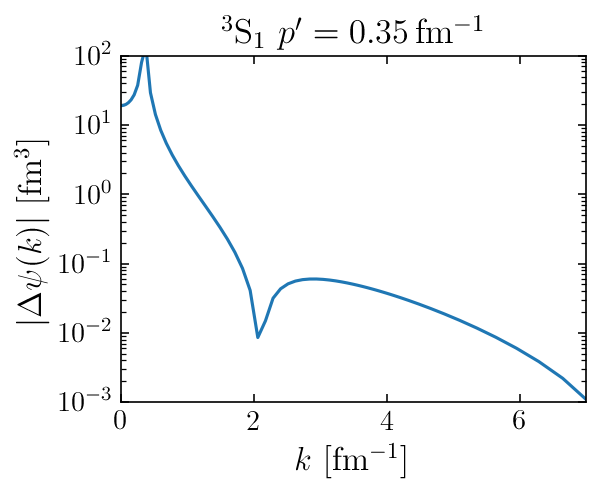

In [16]:
pp = 0.35
# plot_delta_psi(pp, x_limits=(0,7), y_limits=(1e-4,1e1))
plot_delta_psi(pp, x_limits=(0,7), y_limits=(1e-3,1e2))

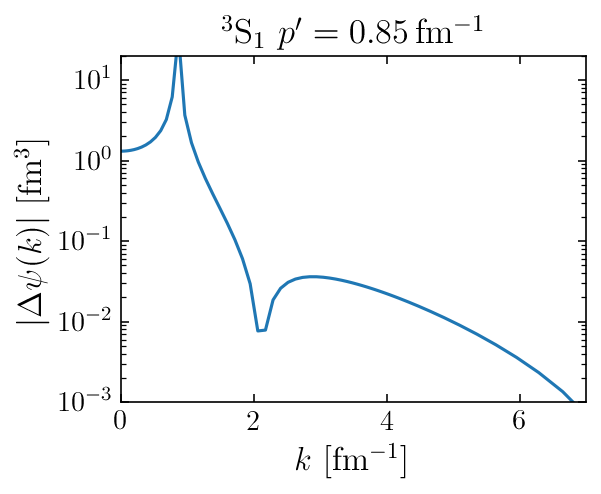

In [17]:
pp = 0.85
plot_delta_psi(pp, x_limits=(0,7), y_limits=(1e-3,2e1))

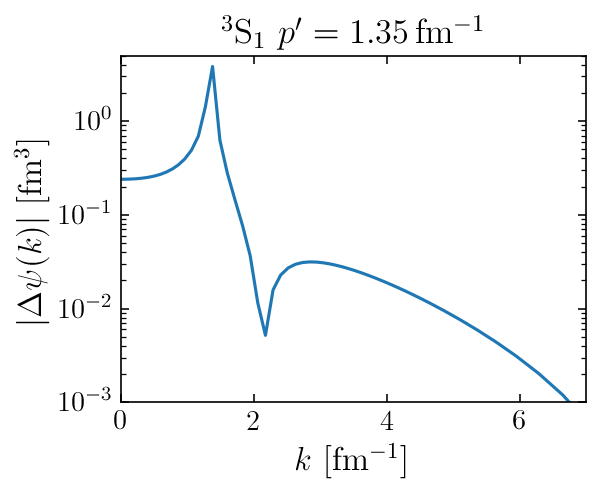

In [18]:
pp = 1.35
plot_delta_psi(pp, x_limits=(0,7), y_limits=(1e-3,5e0))

## Testing unevolved impulse approximation

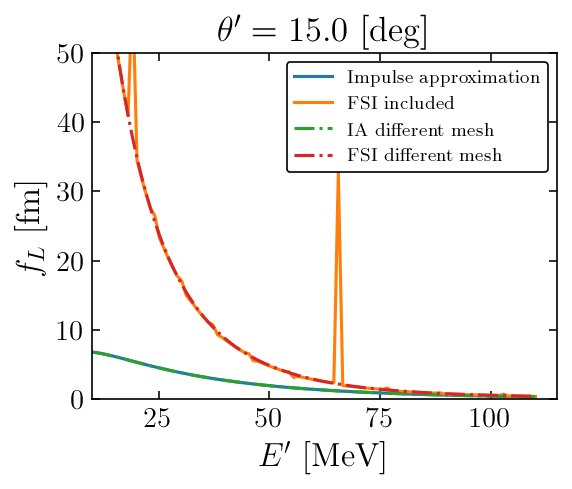

In [19]:
# Quasifree ridge where \omega = 0
Ep_array = np.linspace(10, 110, 100)
thetap = 15.0
# plot_fL_wrt_Ep(Ep_array, thetap, x_limits=(10,115), y_limits=(0,6))
plot_fL_wrt_Ep(Ep_array, thetap, x_limits=(10,115), y_limits=(0,50))
# plot_fL_wrt_Ep(Ep_array, thetap, x_limits=(10,115), y_limits=(0,10))

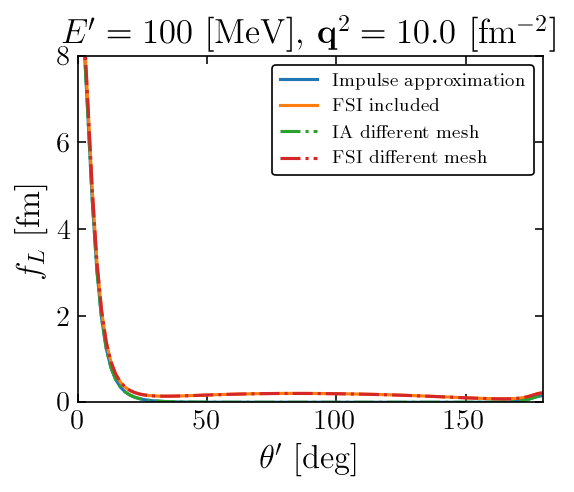

In [20]:
Ep = 100
q = np.sqrt(10)
thetap_array = np.linspace(0.01, 179.9, 100)
plot_fL_wrt_thetap(Ep, thetap_array, q, x_limits=(0,180), y_limits=(0,8))

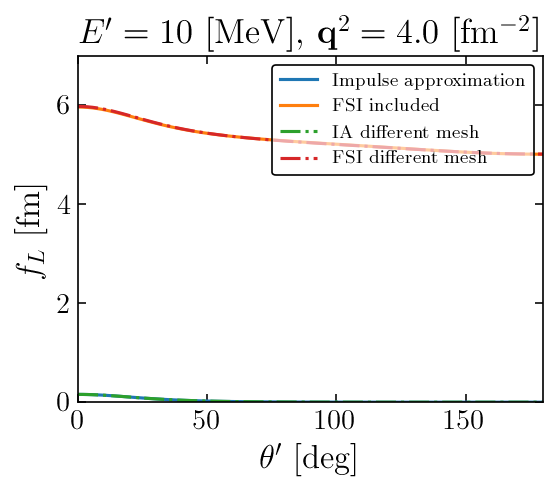

In [28]:
# y-limits for normal scale
# ylim = (0, 0.15)
# y-limits for before TMatrix.channel bug fix
# ylim = (0, 20)
# y-limits for after TMatrix.channel bug fix
ylim = (0, 7)

Ep = 10
q = 2
thetap_array = np.linspace(0.01, 179.9, 100)
plot_fL_wrt_thetap(Ep, thetap_array, q, x_limits=(0,180), y_limits=ylim)

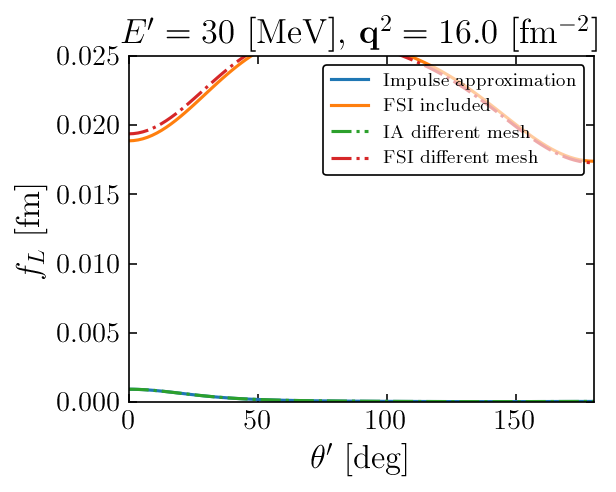

In [22]:
Ep = 30
q = 4
thetap_array = np.linspace(0.01, 179.9, 100)
# plot_fL_wrt_thetap(Ep, thetap_array, q, x_limits=(0,180), y_limits=(0,0.0025))
plot_fL_wrt_thetap(Ep, thetap_array, q, x_limits=(0,180), y_limits=(0,0.025))

In [23]:
# # Off by a constant?
# print(6.805206057495117 / 5.15)
# print(9.699601793093308 / 7.1)
# print(0.15917413078230402 / 0.1295348837209302)
# # print(np.sqrt(np.pi/2))

# # Point at \theta'=180 in E'=100 MeV plot
# print(0.15294739109682806 / 0.11838006230529352)

In [24]:
# pp = 0.1
# thetap = 90.0
# q_array = np.linspace(0, 12, 100)

# # # x and y limits in More (2017) Fig. 20
# # xlim = (0, 12)
# # ylim = (1e-7, 1e0)

# xlim = (0, 12)
# ylim = (1e-7, 1e1)
# plot_fL_wrt_q(pp, thetap, q_array, x_limits=xlim, y_limits=ylim)

In [25]:
de1 = DeuteronElectrodisintegration(kmax=30.0, kmid=4.0, ntot=120)
de2 = DeuteronElectrodisintegration(kmax=25.0, kmid=4.0, ntot=120)
de3 = DeuteronElectrodisintegration(kmax=15.0, kmid=3.0, ntot=120)
Ep_array = np.linspace(10, 110, 100)
pp_array = de1.p_prime(Ep_array / de1.hbar_c)

In [26]:
# print(Ep_array[50:65])

for i, ipp in enumerate(pp_array[50:65]):
    
    print(f"\np' = {ipp:.5f}")
    k1 = de1.k_array
    k2 = de2.k_array
    k3 = de3.k_array
    g1 = np.abs(1 / (ipp ** 2 - k1 ** 2))
    g2 = np.abs(1 / (ipp ** 2 - k2 ** 2))
    g3 = np.abs(1 / (ipp ** 2 - k3 ** 2))
    print(f"kmax 30 mesh: {max(g1):.5e}")
    print(f"kmax 25 mesh: {max(g2):.5e}")
    print(f"kmax 15 mesh: {max(g3):.5e}")


p' = 1.21757
kmax 30 mesh: 7.96631e+00
kmax 25 mesh: 1.76178e+01
kmax 15 mesh: 3.61082e+01

p' = 1.22785
kmax 30 mesh: 9.96209e+00
kmax 25 mesh: 3.16330e+01
kmax 15 mesh: 3.92714e+02

p' = 1.23806
kmax 30 mesh: 1.32945e+01
kmax 25 mesh: 1.55006e+02
kmax 15 mesh: 4.42187e+01

p' = 1.24818
kmax 30 mesh: 1.99820e+01
kmax 25 mesh: 5.34103e+01
kmax 15 mesh: 2.09252e+01

p' = 1.25823
kmax 30 mesh: 4.02293e+01
kmax 25 mesh: 2.27736e+01
kmax 15 mesh: 1.37030e+01

p' = 1.26821
kmax 30 mesh: 2.91502e+03
kmax 25 mesh: 1.44695e+01
kmax 15 mesh: 1.03269e+01

p' = 1.27811
kmax 30 mesh: 3.91287e+01
kmax 25 mesh: 1.06017e+01
kmax 15 mesh: 1.39624e+01

p' = 1.28794
kmax 30 mesh: 1.96915e+01
kmax 25 mesh: 8.36461e+00
kmax 15 mesh: 2.15545e+01

p' = 1.29770
kmax 30 mesh: 1.31539e+01
kmax 25 mesh: 9.48304e+00
kmax 15 mesh: 4.72720e+01

p' = 1.30739
kmax 30 mesh: 9.87399e+00
kmax 25 mesh: 1.24691e+01
kmax 15 mesh: 2.43975e+02

p' = 1.31702
kmax 30 mesh: 7.90250e+00
kmax 25 mesh: 1.82042e+01
kmax 15 mesh: 

In [27]:
de1.E_prime(1.26821)

65.55590347355407